# GPU setup(edit -> Notebook Setting)

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2021-12-13 04:20:21.362509: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Found GPU at: /device:GPU:0


2021-12-13 04:20:23.205960: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-13 04:20:23.209588: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-13 04:20:23.708994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-13 04:20:23.709486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz coreCount: 5 deviceMemorySize: 2.00GiB deviceMemoryBandwidth: 104.43GiB/s
2021

In [ ]:
!nvidia-smi

Mon Dec 13 04:20:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 471.96       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0    N/A /  N/A |    225MiB /  2048MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data

In [ ]:
import numpy as np
# take a subset of all data, shuffle them as well
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
subset_ratio = 0.1

train_index = np.random.permutation(len(x_train))
test_index = np.random.permutation(len(x_test))

train_index = train_index[: int(len(train_index) * subset_ratio)]
test_index = test_index[: int(len(test_index) * subset_ratio)]

x_train,y_train = x_train[train_index],y_train[train_index]
x_test,y_test = x_test[test_index],y_test[test_index]

# Baseline Resnet

In [ ]:
# credit https://arxiv.org/abs/1512.03385
from pathlib import Path
if Path("./resnet_cifar10.py").is_file():
    pass
else:
    !wget https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py
    
import resnet_cifar10

In [ ]:
# formulae from original implementation credit: https://arxiv.org/abs/1512.03385
def get_n_block_from_depth(depth):
  n_blocks = ((depth - 2) // 9) - 1
  return n_blocks

In [ ]:

# this is adapted from credit: https://github.com/sayakpaul/Training-BatchNorm-and-Only-BatchNorm/blob/master/CIFAR10_Subset.ipynb
def get_Res_N(depth,n_categories):
    n_blocks = get_n_block_from_depth(depth)

    inputs = tf.keras.layers.Input(shape=(32, 32, 3))

    x = resnet_cifar10.stem(inputs)

    x = resnet_cifar10.learner(x, n_blocks)

    outputs = resnet_cifar10.classifier(x, n_categories)

    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
# baseline model
base_line = get_Res_N(200,10)
base_line.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h_base = base_line.fit(x_train,y_train,
         validation_data=(x_test,y_test),
         epochs=30,verbose=1)

Epoch 1/30
157/157 [==============================] - 78s 378ms/step - loss: 1.9343 - accuracy: 0.2916 - val_loss: 3.6799 - val_accuracy: 0.2240
Epoch 2/30
157/157 [==============================] - 59s 375ms/step - loss: 1.6318 - accuracy: 0.4022 - val_loss: 2.1393 - val_accuracy: 0.2950
Epoch 3/30
157/157 [==============================] - 61s 389ms/step - loss: 1.4836 - accuracy: 0.4558 - val_loss: 2.9868 - val_accuracy: 0.2190
Epoch 4/30
157/157 [==============================] - 60s 380ms/step - loss: 1.3838 - accuracy: 0.4956 - val_loss: 1.8180 - val_accuracy: 0.3870
Epoch 5/30
157/157 [==============================] - 58s 369ms/step - loss: 1.2622 - accuracy: 0.5440 - val_loss: 3.0293 - val_accuracy: 0.3050
Epoch 6/30
157/157 [==============================] - 58s 369ms/step - loss: 1.1679 - accuracy: 0.5826 - val_loss: 1.8937 - val_accuracy: 0.4220
Epoch 7/30
157/157 [==============================] - 57s 363ms/step - loss: 1.0707 - accuracy: 0.6090 - val_loss: 1.7671 - val_ac

In [ ]:
import matplotlib.pyplot as plt
def show_history(x,history:dict,title=""):
    plt.figure()
    plt.title(title + " Loss/Accuracy vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    for key,value in history.items():
        plt.plot(x,value,label = key)
    plt.legend()
    plt.show()

	

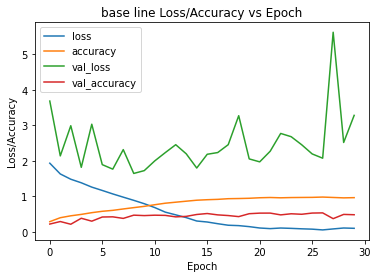

In [ ]:
show_history(np.arange(30),h_base.history,"base line")

# Claim 1: When training only γ and β, sufficiently deep networks (e.g., ResNet-866 and ResNet-200) reach surprisingly high (although non-SOTA) accuracy: 82% on CIFAR-10 and 32% top-5 on ImageNet. This demonstrates the expressive power of the affine BatchNorm parameters.

In [ ]:
# freeze all except batchnorm parameters credit: https://github.com/sayakpaul/Training-BatchNorm-and-Only-BatchNorm/blob/master/CIFAR10_Subset.ipynb
res200_bn_only = get_Res_N(200,10)
for layer in res200_bn_only.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        if hasattr(layer, "trainable"):
            layer.trainable=False
            
res200_bn_only.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h_bn_only = res200_bn_only.fit(x_train,y_train,
         validation_data=(x_test,y_test),
         epochs=30)

Epoch 1/30
157/157 [==============================] - 61s 275ms/step - loss: 2.2928 - accuracy: 0.1328 - val_loss: 2.4976 - val_accuracy: 0.1300
Epoch 2/30
157/157 [==============================] - 41s 263ms/step - loss: 2.2555 - accuracy: 0.1642 - val_loss: 2.2710 - val_accuracy: 0.1670
Epoch 3/30
157/157 [==============================] - 40s 255ms/step - loss: 2.2309 - accuracy: 0.1826 - val_loss: 2.2445 - val_accuracy: 0.1820
Epoch 4/30
157/157 [==============================] - 40s 256ms/step - loss: 2.2054 - accuracy: 0.2072 - val_loss: 2.2164 - val_accuracy: 0.1880
Epoch 5/30
157/157 [==============================] - 40s 253ms/step - loss: 2.1756 - accuracy: 0.2164 - val_loss: 2.1815 - val_accuracy: 0.1860
Epoch 6/30
157/157 [==============================] - 39s 249ms/step - loss: 2.1287 - accuracy: 0.2216 - val_loss: 2.1368 - val_accuracy: 0.2060
Epoch 7/30
157/157 [==============================] - 39s 249ms/step - loss: 2.0823 - accuracy: 0.2358 - val_loss: 2.0975 - val_ac

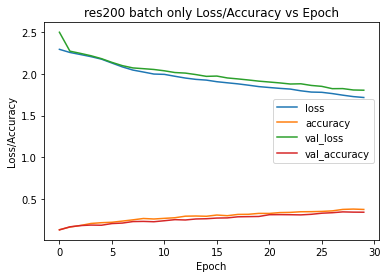

In [ ]:
show_history(np.arange(30),h_bn_only.history,"res200 batch only")

# Claim 2 : When training only BatchNorm, γ naturally learns to disable between a quarter to half of all channels by converging to values close to zero. This demonstrates that γ and β achieve this accuracy in part by imposing per-feature sparsity.

In [ ]:
res10_bn_only = get_Res_N(10,10)

for layer in res10_bn_only.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        if hasattr(layer, "trainable"):
            layer.trainable=False
            
res10_bn_only.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

h_res_10 = res10_bn_only.fit(x_train,y_train,
         validation_data=(x_test,y_test),
         epochs=100)

Epoch 1/100
157/157 [==============================] - 5s 28ms/step - loss: 2.3548 - accuracy: 0.1092 - val_loss: 2.3312 - val_accuracy: 0.1210
Epoch 2/100
157/157 [==============================] - 4s 26ms/step - loss: 2.2362 - accuracy: 0.1826 - val_loss: 2.2199 - val_accuracy: 0.1820
Epoch 3/100
157/157 [==============================] - 4s 26ms/step - loss: 2.1656 - accuracy: 0.2350 - val_loss: 2.1630 - val_accuracy: 0.2160
Epoch 4/100
157/157 [==============================] - 4s 26ms/step - loss: 2.1098 - accuracy: 0.2620 - val_loss: 2.1124 - val_accuracy: 0.2300
Epoch 5/100
157/157 [==============================] - 4s 27ms/step - loss: 2.0585 - accuracy: 0.2754 - val_loss: 2.0720 - val_accuracy: 0.2480
Epoch 6/100
157/157 [==============================] - 4s 27ms/step - loss: 2.0182 - accuracy: 0.2934 - val_loss: 2.0408 - val_accuracy: 0.2490
Epoch 7/100
157/157 [==============================] - 4s 26ms/step - loss: 1.9916 - accuracy: 0.2944 - val_loss: 2.0175 - val_accuracy:

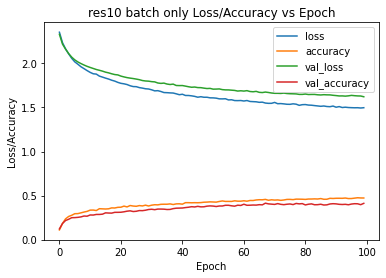

In [ ]:
show_history(np.arange(100),h_res_10.history,"res10 batch only")

In [ ]:
import string

def average_gamma_and_zero_ratio(model,epsilon=0.01):
  close_to_zero = 0
  sum = 0
  total_count = 0
  for layer_weights in model.trainable_weights:
    if layer_weights.name.find('gamma') != -1:
      total_count += layer_weights.shape[0]
      sum += np.sum(layer_weights)
      close_to_zero += layer_weights[np.abs(layer_weights) < epsilon].shape[0]

  average_y = sum / total_count
  close_to_zero_ratio = close_to_zero / total_count
  return(average_y,close_to_zero_ratio)


In [ ]:
print(average_gamma_and_zero_ratio(base_line))

(1.001002418005615, 0.0)


In [ ]:
print(average_gamma_and_zero_ratio(res200_bn_only))

(0.9810900366157912, 0.0)


In [ ]:
print(average_gamma_and_zero_ratio(res10_bn_only))

(1.0866390088914146, 0.0008802816901408451)


# Claim 3: Training an equivalent number of randomly-selected parameters per channel performs far worse (56% on CIFAR-10 and 4% top-5 on ImageNet). This demonstrates that γ and β have particularly significant expressive power as per-feature coefficients and biases.

In [ ]:
# randomize batch norm weights and freeze
import tensorflow as tf
frozen = get_Res_N(100,10)

for layer in frozen.layers:
  if isinstance(layer,tf.keras.layers.BatchNormalization):
    for weights in layer.weights:
      weights.assign(np.random.rand(weights.shape[0]))
    if hasattr(layer, "trainable"):
      layer.trainable=False

frozen.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h_frozen = frozen.fit(x_train,y_train,
         validation_data=(x_test,y_test),
         epochs=30,verbose=1)

Epoch 1/30
157/157 [==============================] - 36s 192ms/step - loss: 205921615872.0000 - accuracy: 0.0932 - val_loss: 224723.9688 - val_accuracy: 0.1050
Epoch 2/30
157/157 [==============================] - 29s 187ms/step - loss: 109465.5234 - accuracy: 0.1160 - val_loss: 79765.3438 - val_accuracy: 0.1220
Epoch 3/30
157/157 [==============================] - 30s 189ms/step - loss: 66125.1484 - accuracy: 0.1374 - val_loss: 61535.0352 - val_accuracy: 0.1260
Epoch 4/30
157/157 [==============================] - 29s 186ms/step - loss: 55296.0508 - accuracy: 0.1442 - val_loss: 60726.3281 - val_accuracy: 0.1260
Epoch 5/30
157/157 [==============================] - 29s 184ms/step - loss: 43756.1680 - accuracy: 0.1552 - val_loss: 44285.8125 - val_accuracy: 0.1440
Epoch 6/30
157/157 [==============================] - 29s 185ms/step - loss: 38110.4844 - accuracy: 0.1682 - val_loss: 39170.0703 - val_accuracy: 0.1530
Epoch 7/30
157/157 [==============================] - 29s 186ms/step - lo

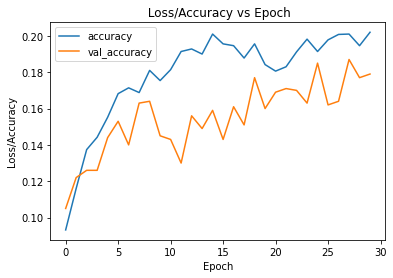

In [ ]:
h_frozen.history.pop("loss")
h_frozen.history.pop("val_loss")
show_history(np.arange(30),h_frozen.history)

# Claim 4: When training all parameters, deeper and wider networks have smaller γ values but few features are outright disabled. This hints at the role γ may play in moderating activations in settings where disabling γ and β leads to lower accuracy

In [ ]:
list = [20, 56, 110]
models = []
histories = []

for i in list:
  model = get_Res_N(i,10)
  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  h = model.fit(x_train,y_train,
         validation_data=(x_test,y_test),
         epochs=30,verbose=1)
  h.history.pop("loss")
  h.history.pop("val_loss")
  models.append(model)
  histories.append(h)


Epoch 1/30
157/157 [==============================] - 10s 53ms/step - loss: 1.8049 - accuracy: 0.3436 - val_loss: 1.9167 - val_accuracy: 0.2960
Epoch 2/30
157/157 [==============================] - 8s 49ms/step - loss: 1.4848 - accuracy: 0.4686 - val_loss: 1.8350 - val_accuracy: 0.3700
Epoch 3/30
157/157 [==============================] - 8s 49ms/step - loss: 1.3090 - accuracy: 0.5366 - val_loss: 2.3712 - val_accuracy: 0.3230
Epoch 4/30
157/157 [==============================] - 8s 50ms/step - loss: 1.1487 - accuracy: 0.5928 - val_loss: 1.7408 - val_accuracy: 0.3850
Epoch 5/30
157/157 [==============================] - 8s 50ms/step - loss: 1.0089 - accuracy: 0.6420 - val_loss: 1.8258 - val_accuracy: 0.3820
Epoch 6/30
157/157 [==============================] - 8s 51ms/step - loss: 0.8638 - accuracy: 0.6978 - val_loss: 3.0474 - val_accuracy: 0.3230
Epoch 7/30
157/157 [==============================] - 8s 49ms/step - loss: 0.7306 - accuracy: 0.7442 - val_loss: 1.7603 - val_accuracy: 0.438

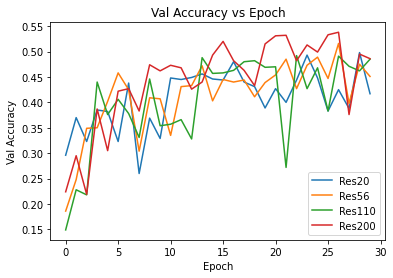

In [ ]:
plt.figure()
plt.title("Val Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.plot(np.arange(30),histories[0].history["val_accuracy"],label = "Res20")
plt.plot(np.arange(30),histories[1].history["val_accuracy"],label = "Res56")
plt.plot(np.arange(30),histories[2].history["val_accuracy"],label = "Res110")
plt.plot(np.arange(30),h_base.history["val_accuracy"],label = "Res200")
plt.legend()
plt.show()

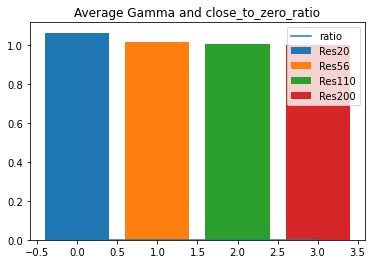

In [ ]:
plt.figure()
plt.title("Average Gamma and close_to_zero_ratio")

plt.bar(0,average_gamma_and_zero_ratio(models[0])[0],label = "Res20")
plt.bar(1,average_gamma_and_zero_ratio(models[1])[0],label = "Res56")
plt.bar(2,average_gamma_and_zero_ratio(models[2])[0],label = "Res110")
plt.bar(3,average_gamma_and_zero_ratio(base_line)[0],label = "Res200")
l =[]
l.append(average_gamma_and_zero_ratio(models[0])[1])
l.append(average_gamma_and_zero_ratio(models[0])[1])
l.append(average_gamma_and_zero_ratio(models[0])[1])
l.append(average_gamma_and_zero_ratio(base_line)[1])
plt.plot(np.arange(4),l,label = "ratio")
plt.legend()
plt.show()